## Exploration of Word Embeddings in the Context of Covid-19 Document Classification
### Imports
(TODO: shortly explain each of the paragraphs/steps)

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch.nn as nn
import torch
from transformers import BertModel, BertTokenizer
from pathlib import Path
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.tokenization import Tokenizer
from farm.infer import Inferencer
from sklearn.manifold import TSNE

### Load the Abstracts
Use the cleaned abstracts in the `train.csv` file to avoid redundant preprocessing.

In [2]:
data = pd.read_csv("../data/document_classification/train.csv", sep = "\t")

# group data by different categories
groups = [g["text"] for _,g in data.groupby(["Categories"])]
category_names = [g.iloc[0]["Categories"] for _,g in data.groupby(["Categories"])]

### Load the Results from the Document Classificaiton

In [3]:
def average_metrics(path, ranges, shp):
    reports = np.empty(shape=shp)

    # add the results of the reports
    for i in range(len(ranges)):
        report = pd.read_csv(path + "classification_report.txt", 
                             skiprows=lambda x: x < ranges[i][0] or x > ranges[i][1], sep="\s{2,}", index_col=0)
        reports[i,:,:] = report.values

    # calculate the average of the metrics
    means = np.mean(reports, axis=0)
    stds = np.std(reports, axis=0)

    # save means and stds per metric per class
    final_report = pd.DataFrame(index=report.index, columns=report.columns.values)
    for i in range(len(report.columns.values)-1):
        final_report.iloc[:,i] = [str(round(i,3)) + "±" + str(round(j,3)) for i,j in zip(means[:,i],stds[:,i])]

    final_report["support"] = np.sum(reports, axis=0)[:,-1].astype(int)

    return final_report

bert_style_ranges = [(1,12), (16,27), (31,42), (46,57), (61,72)]
bert_shape = (5,9,4)
doc2vec_ranges = [(1,11), (15,25), (29,39), (43,53), (57,67)]
doc2vec_shape = (5,8,4)

average_bert = average_metrics("./saved_models/covid-classification-best-model-06222020-13:16:29/", 
                              bert_style_ranges, bert_shape)
average_biobert = average_metrics("./saved_models/covid-classification-best-model-06222020-16:08:56/",
                                 bert_style_ranges, bert_shape)
average_covidbert = average_metrics("./saved_models/covid-classification-best-model-06222020-17:12:30/",
                                   bert_style_ranges, bert_shape)
average_doc2vec = average_metrics("./saved_models/covid-doc2vec/", doc2vec_ranges, doc2vec_shape)

averages = [average_bert, average_biobert, average_covidbert, average_doc2vec]
model_names = ["BERT", "BioBERT", "CovidBERT", "Doc2Vec"]

print(average_doc2vec)

                precision       recall     f1-score              support
Case Report   0.568±0.042  0.496±0.066  0.528±0.052                  297
Diagnosis     0.592±0.039  0.504±0.029  0.544±0.029                  904
Mechanism     0.436±0.051  0.366±0.048  0.398±0.047                  495
Prevention    0.786±0.028  0.872±0.017  0.828±0.021                 2216
Treatment     0.628±0.026  0.622±0.057  0.626±0.036                 1356
accuracy      0.676±0.027  1053.6±0.49      nan±nan -9223372036854775808
macro avg     0.602±0.029  0.572±0.032   0.586±0.03                 5268
weighted avg  0.666±0.027  0.676±0.027   0.67±0.028                 5268


/home/hbalabin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


### Visualize the Results

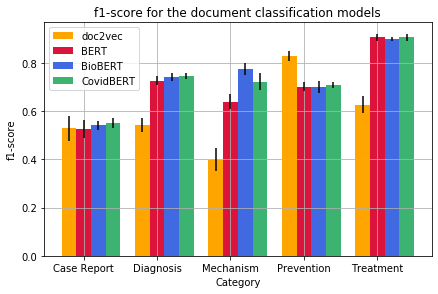

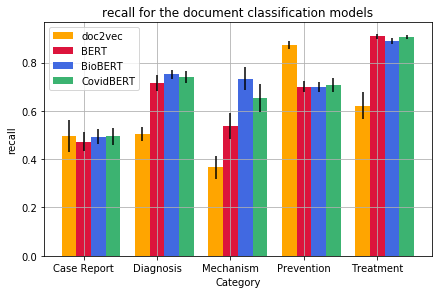

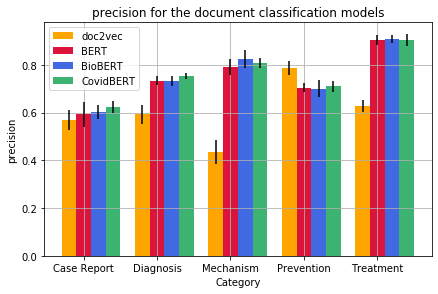

In [81]:
def visualize(metric):
    x = np.arange(len(category_names)
                 ) # the x locations for the groups
    width = 0.35         # the width of the bars

    plt.rcParams.update({'font.size': 10})
    av_doc2vec = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_doc2vec.iloc[:5][metric]]
    av_bert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_bert.iloc[:5][metric]]
    av_biobert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_biobert.iloc[:5][metric]]
    av_covidbert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_covidbert.iloc[:5][metric]]

    ax = plt.subplot(111)
    ax.bar(x-0.2, [i[0] for i in av_doc2vec], width=0.2, color='orange', align='center', 
           yerr=[i[1] for i in av_doc2vec], label="doc2vec")
    ax.bar(x, [i[0] for i in av_bert], width=0.2, color='crimson', align='center', 
           yerr=[i[1] for i in av_bert], label="BERT")
    ax.bar(x+0.2, [i[0] for i in av_biobert], width=0.2, color='royalblue', align='center', 
           yerr=[i[1] for i in av_biobert], label="BioBERT")
    ax.bar(x+0.4, [i[0] for i in av_covidbert], width=0.2, color='mediumseagreen', align='center', 
           yerr=[i[1] for i in av_covidbert], label="CovidBERT")

    ax.set_title(metric + " for the document classification models")
    ax.legend()
    
    plt.tight_layout()
    plt.xticks(x, ["Case Report", "Diagnosis", "Mechanism", "Prevention", "Treatment"])
    plt.xlabel("Category")
    plt.ylabel(metric)
    plt.grid()
    plt.savefig("../data/visualization/" + metric + "-document-classification-results.png")
    plt.show() 
    
visualize("f1-score")
visualize("recall")
visualize("precision")

### Extracting the Most Frequent Unigrams in the Text, Grouped by Category

In [5]:
def create_ngrams(abstract_texts, min_occ):
    vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r'\S+')
    text_ngrams = vectorizer.fit_transform(abstract_texts)
    features = vectorizer.get_feature_names()

    vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r'\S+') # You can still specify n-grams here.
    ngrams_tfidf = vectorizer.fit_transform(abstract_texts)
    
    # Getting top ranking features 
    sums = ngrams_tfidf.sum(axis = 0)
    sums2 = text_ngrams.sum(axis = 0)
    data = [] 
    for col, term in enumerate(features): 
        data.append((term, sums2[0,col], sums[0,col])) 
    ranking = pd.DataFrame(data, columns = ['unigrams','frequency', 'rank_tf-idf']) 
    ranking['relative_frequency'] = ranking['frequency'] / ranking['frequency'].sum()
    # rank by tf-idf
    words = (ranking.sort_values('rank_tf-idf', ascending = False)) 
    # prune those that only appear once. alternatively, select all those under a certain tf-idf
    words = words[words.frequency >= min_occ]
    # just swap so that tf-idf is at the end...
    words = words[['unigrams','frequency', 'relative_frequency', 'rank_tf-idf']]
    
    # print("\n\n")
    # print(words[:25])
    
    return words


most_common_terms = [create_ngrams(g, 5) for g in groups]
common_unigrams = set(most_common_terms[0]["unigrams"])

for i in most_common_terms[1:]:
    common_unigrams = common_unigrams.intersection(i["unigrams"])

# lets take 25 words in each list that are not in the other ones 
unique_unigrams = [[i for i in j["unigrams"] if i not in common_unigrams][:25] for j in most_common_terms]
print([i for i in unique_unigrams])

[['transplant', 'recipient', 'man', 'stroke', 'surgery', 'ground-glass', 'hiv', 'surgical', 'coronary', 'hydroxychloroquine', 'ecmo', 'discharge', 'x-ray', 'healthcare', 'hour', "patient's", 'hemodialysis', 'supportive', 'thrombosis', 'facility', 'artery', 'procedure', 'covid', 'managed', 'cesarean'], ['ci', 'sensitivity', 'model', 'igg', 'igm', 'image', 'consolidation', 'specificity', 'prevalence', 'cohort', 'performance', 'mean', 'healthcare', 'difference', 'ground-glass', 'lobe', 'crp', 'tool', 'distribution', 'ultrasound', 'anosmia', 'ggo', 'p0001', 'smell', 'enrolled'], ['ace2', 'sequence', 'host', 'coronaviruses', 'genome', 'bat', 'vaccine', 'spike', 'animal', 'expression', 'cov', 'structure', 'binding', 'mers-cov', 'mutation', 'pathogenesis', 'mers', 'model', 'covs', 'interaction', 'rbd', 'domain', 'activity', 'east', 'enzyme'], ['healthcare', 'surgery', 'practice', 'service', 'procedure', 'surgical', 'recommendation', 'model', 'guideline', 'equipment', 'personal', 'lockdown', '

### Load the Trained Models and Obtaining the Embeddings of the Unigrams

In [26]:
def get_embeddings(file_name, words):
    # restore saved fine-tuned model
    save_dir = Path(file_name)
    model = AdaptiveModel.load(save_dir, "cpu").language_model
    tokenizer = Tokenizer.load(save_dir)

    # Input
    basic_texts = [{"text": words}]

    # Load model, tokenizer and processor directly into Inferencer
    model = Inferencer.load(file_name, task_type="embeddings", extraction_strategy="per_token", extraction_layer=-2, num_processes=0)
    # Get embeddings for input text (you can vary the strategy and layer)
    result = model.extract_vectors(dicts=basic_texts, extraction_strategy="per_token")
    return result[0]["vec"][:25]
    
# these models are only available locally on my machine (due to the size I didn't include them in the git repo)
bert_embeddings_per_topic = [get_embeddings("./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model",
              " ".join(words)) for words in unique_unigrams]    
biobert_embeddings_per_topic = [get_embeddings("./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model",
              " ".join(words)) for words in unique_unigrams]  
covidbert_embeddings_per_topic = [get_embeddings("./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model",
              " ".join(words)) for words in unique_unigrams]  

06/30/2020 11:41:17 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin
06/30/2020 11:41:18 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:18 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:18 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:18 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/prediction_head_0.bin
06/30/2020 11:41:18 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/2020 11:41:18 - INFO - transformers.tokenization_utils -   Model name 'saved_models/covid-

06/30/2020 11:41:20 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: transplant recipient man stroke surgery ground-glass hiv surgical coronary hydroxychloroquine ecmo discharge x-ray healthcare hour patient's hemodialysis supportive thrombosis facility artery procedure covid managed cesarean
Tokenized: 
 	tokens: ['transplant', 'recipient', 'man', 'stroke', 'surgery', 'ground', '-', 'glass', 'hiv', 'surgical', 'corona', '##ry', 'hydro', '##xy', '##ch', '##lor', '##o', '##quin', '##e', 'ec', '##mo', 'discharge',

06/30/2020 11:41:24 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:24 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/vocab.txt
06/30/2020 11:41:24 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:24 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/special_tokens_map.json
06/30/2020 11:41:24 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/tokenizer_config.json
06/30/2020 11:41:24 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:24 - WARNING - farm.infer -   Deprecated! Please us

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.57 Batches/s]
06/30/2020 11:41:24 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin
06/30/2020 11:41:25 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:25 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:25 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:25 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/prediction_head_0.bin
06/30/2020 11:41:25 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/2020 11:41:25 - I

06/30/2020 11:41:27 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: ace2 sequence host coronaviruses genome bat vaccine spike animal expression cov structure binding mers-cov mutation pathogenesis mers model covs interaction rbd domain activity east enzyme
Tokenized: 
 	tokens: ['ace', '##2', 'sequence', 'host', 'corona', '##virus', '##es', 'genome', 'bat', 'vaccine', 'spike', 'animal', 'expression', 'co', '##v', 'structure', 'binding', 'mer', '##s', '-', 'co', '##v', 'mutation', 'pathogen', '##esis', 'mer', '#

06/30/2020 11:41:31 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:31 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/vocab.txt
06/30/2020 11:41:31 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:31 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/special_tokens_map.json
06/30/2020 11:41:31 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/tokenizer_config.json
06/30/2020 11:41:31 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:31 - WARNING - farm.infer -   Deprecated! Please us

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.72 Batches/s]
06/30/2020 11:41:31 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/language_model.bin
06/30/2020 11:41:32 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:32 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:32 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:32 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-13:16:29/bert_model/prediction_head_0.bin
06/30/2020 11:41:32 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/2020 11:41:32 - I

06/30/2020 11:41:34 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: ace2 vaccine inhibitor hydroxychloroquine chloroquine binding hcq compound ci plasma remdesivir activity host arb enzyme expression protease coronaviruses recommendation spike treat angiotensin corticosteroid guideline approved
Tokenized: 
 	tokens: ['ace', '##2', 'vaccine', 'inhibitor', 'hydro', '##xy', '##ch', '##lor', '##o', '##quin', '##e', 'ch', '##lor', '##o', '##quin', '##e', 'binding', 'hc', '##q', 'compound', 'ci', 'plasma', 're', '##m

06/30/2020 11:41:37 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:37 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/vocab.txt
06/30/2020 11:41:37 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:37 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/special_tokens_map.json
06/30/2020 11:41:37 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/tokenizer_config.json
06/30/2020 11:41:37 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:37 - WARNING - farm.infer -   Deprecate

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.96 Batches/s]
06/30/2020 11:41:38 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/language_model.bin
06/30/2020 11:41:39 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:39 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:39 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:39 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/prediction_head_0.bin
06/30/2020 11:41:39 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/2020 11:

06/30/2020 11:41:41 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: ci sensitivity model igg igm image consolidation specificity prevalence cohort performance mean healthcare difference ground-glass lobe crp tool distribution ultrasound anosmia ggo p0001 smell enrolled
Tokenized: 
 	tokens: ['c', '##i', 'sensitivity', 'model', 'i', '##gg', 'i', '##g', '##m', 'image', 'consolidation', 'specific', '##ity', 'prevalence', 'co', '##hor', '##t', 'performance', 'mean', 'healthcare', 'difference', 'ground', '-', 'glass

06/30/2020 11:41:44 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:44 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/vocab.txt
06/30/2020 11:41:44 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:44 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/special_tokens_map.json
06/30/2020 11:41:44 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/tokenizer_config.json
06/30/2020 11:41:44 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:44 - WARNING - farm.infer -   Deprecate

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.68 Batches/s]
06/30/2020 11:41:44 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/language_model.bin
06/30/2020 11:41:46 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:46 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:46 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:46 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/prediction_head_0.bin
06/30/2020 11:41:46 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/2020 11:

06/30/2020 11:41:47 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: healthcare surgery practice service procedure surgical recommendation model guideline equipment personal lockdown mask telemedicine distancing activity policy professional ppe surgeon government society international face survey
Tokenized: 
 	tokens: ['healthcare', 'surgery', 'practice', 'service', 'procedure', 'surgical', 'recommendation', 'model', 'guide', '##line', 'equipment', 'personal', 'lock', '##down', 'mask', 'te', '##lem', '##edic', '

06/30/2020 11:41:51 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:51 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/vocab.txt
06/30/2020 11:41:51 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:51 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/special_tokens_map.json
06/30/2020 11:41:51 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-16:08:56/biobert_model/tokenizer_config.json
06/30/2020 11:41:51 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:51 - WARNING - farm.infer -   Deprecate

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.90 Batches/s]
06/30/2020 11:41:51 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin
06/30/2020 11:41:52 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:52 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:52 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:52 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/prediction_head_0.bin
06/30/2020 11:41:52 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/20

06/30/2020 11:41:54 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: transplant recipient man stroke surgery ground-glass hiv surgical coronary hydroxychloroquine ecmo discharge x-ray healthcare hour patient's hemodialysis supportive thrombosis facility artery procedure covid managed cesarean
Tokenized: 
 	tokens: ['transplant', 'recipient', 'man', 'stroke', 'surgery', 'ground', '-', 'glass', 'hiv', 'surgical', 'corona', '##ry', 'hydro', '##xy', '##ch', '##lor', '##o', '##quin', '##e', 'ec', '##mo', 'discharge',

06/30/2020 11:41:58 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/added_tokens.json. We won't load it.
06/30/2020 11:41:58 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/vocab.txt
06/30/2020 11:41:58 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:41:58 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/special_tokens_map.json
06/30/2020 11:41:58 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/tokenizer_config.json
06/30/2020 11:41:58 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:41:58 - WARNING - farm.infer -   D

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.98 Batches/s]
06/30/2020 11:41:58 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin
06/30/2020 11:41:59 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:41:59 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:41:59 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:41:59 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/prediction_head_0.bin
06/30/2020 11:41:59 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/20

06/30/2020 11:42:01 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: ace2 sequence host coronaviruses genome bat vaccine spike animal expression cov structure binding mers-cov mutation pathogenesis mers model covs interaction rbd domain activity east enzyme
Tokenized: 
 	tokens: ['ace', '##2', 'sequence', 'host', 'corona', '##virus', '##es', 'genome', 'bat', 'vaccine', 'spike', 'animal', 'expression', 'co', '##v', 'structure', 'binding', 'mer', '##s', '-', 'co', '##v', 'mutation', 'pathogen', '##esis', 'mer', '#

06/30/2020 11:42:05 - INFO - transformers.tokenization_utils -   Didn't find file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/added_tokens.json. We won't load it.
06/30/2020 11:42:05 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/vocab.txt
06/30/2020 11:42:05 - INFO - transformers.tokenization_utils -   loading file None
06/30/2020 11:42:05 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/special_tokens_map.json
06/30/2020 11:42:05 - INFO - transformers.tokenization_utils -   loading file ./saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/tokenizer_config.json
06/30/2020 11:42:05 - INFO - farm.utils -   device: cpu n_gpu: 0, distributed training: False, automatic mixed precision training: None
06/30/2020 11:42:05 - WARNING - farm.infer -   D

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  4.71 Batches/s]
06/30/2020 11:42:05 - INFO - transformers.modeling_utils -   loading weights file saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin from cache at saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/language_model.bin
06/30/2020 11:42:06 - INFO - farm.modeling.adaptive_model -   Found files for loading 1 prediction heads
06/30/2020 11:42:06 - WARNING - farm.modeling.prediction_head -   `layer_dims` will be deprecated in future releases
06/30/2020 11:42:06 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 5]
06/30/2020 11:42:06 - INFO - farm.modeling.prediction_head -   Loading prediction head from saved_models/covid-classification-best-model-06222020-17:12:30/covidbert_model/prediction_head_0.bin
06/30/2020 11:42:06 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'
06/30/20

06/30/2020 11:42:08 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ __ ___  _ __ | | ___ 
      "||"       \___ \ / _` | '_ ` _ \| '_ \| |/ _ \ 
       || /\     ____) | (_| | | | | | | |_) | |  __/
    /\ ||//\)   |_____/ \__,_|_| |_| |_| .__/|_|\___|
   (/\||/                             |_|           
______\||/___________________________________________                     

ID: train-0-0
Clear Text: 
 	text: ace2 vaccine inhibitor hydroxychloroquine chloroquine binding hcq compound ci plasma remdesivir activity host arb enzyme expression protease coronaviruses recommendation spike treat angiotensin corticosteroid guideline approved
Tokenized: 
 	tokens: ['ace', '##2', 'vaccine', 'inhibitor', 'hydro', '##xy', '##ch', '##lor', '##o', '##quin', '##e', 'ch', '##lor', '##o', '##quin', '##e', 'binding', 'hc', '##q', 'compound', 'ci', 'plasma', 're', '##m

### t-SNE Visualization 

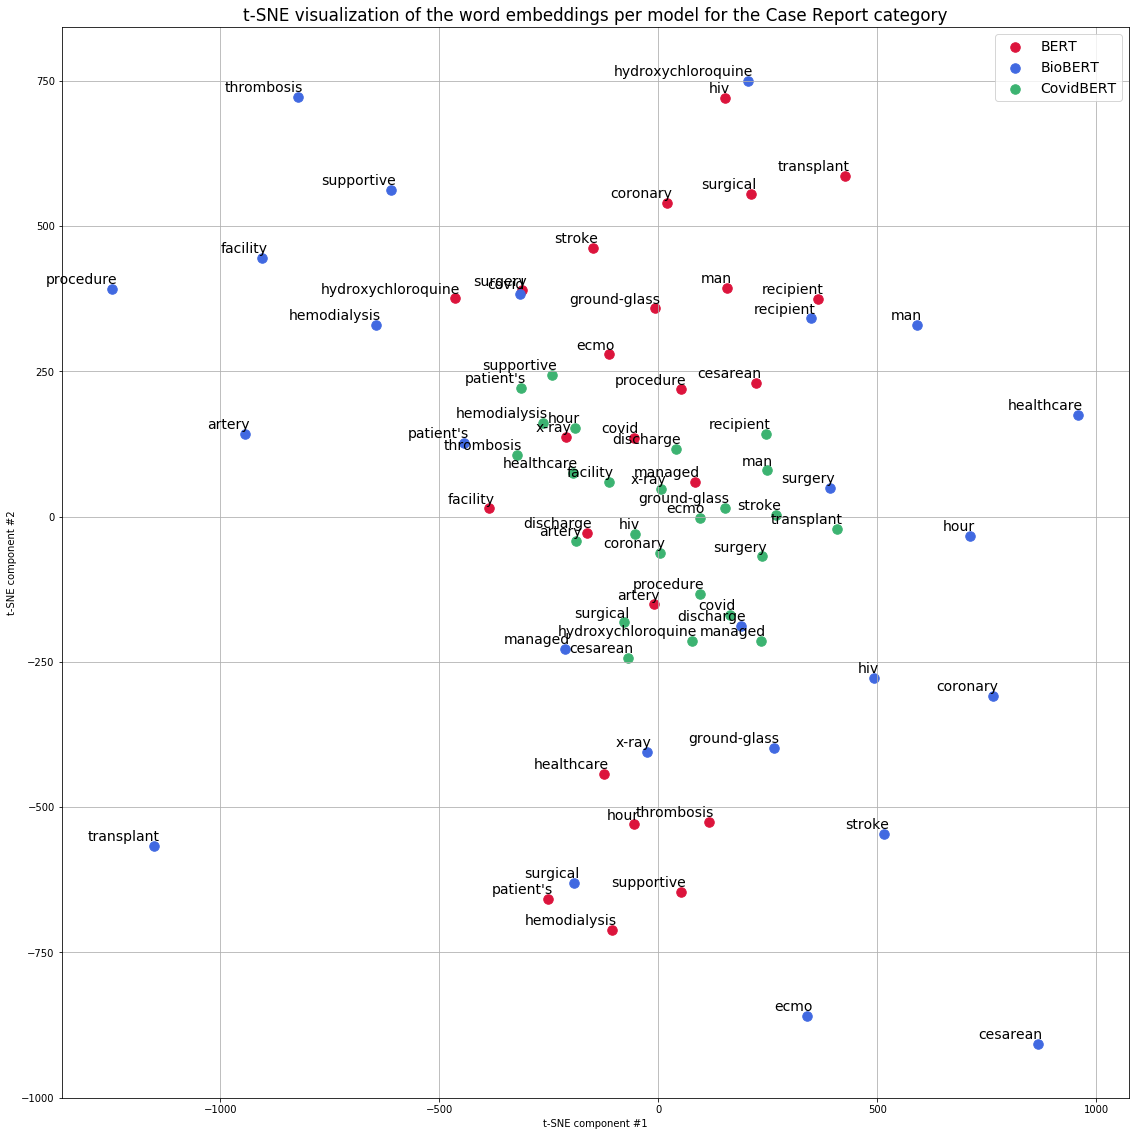

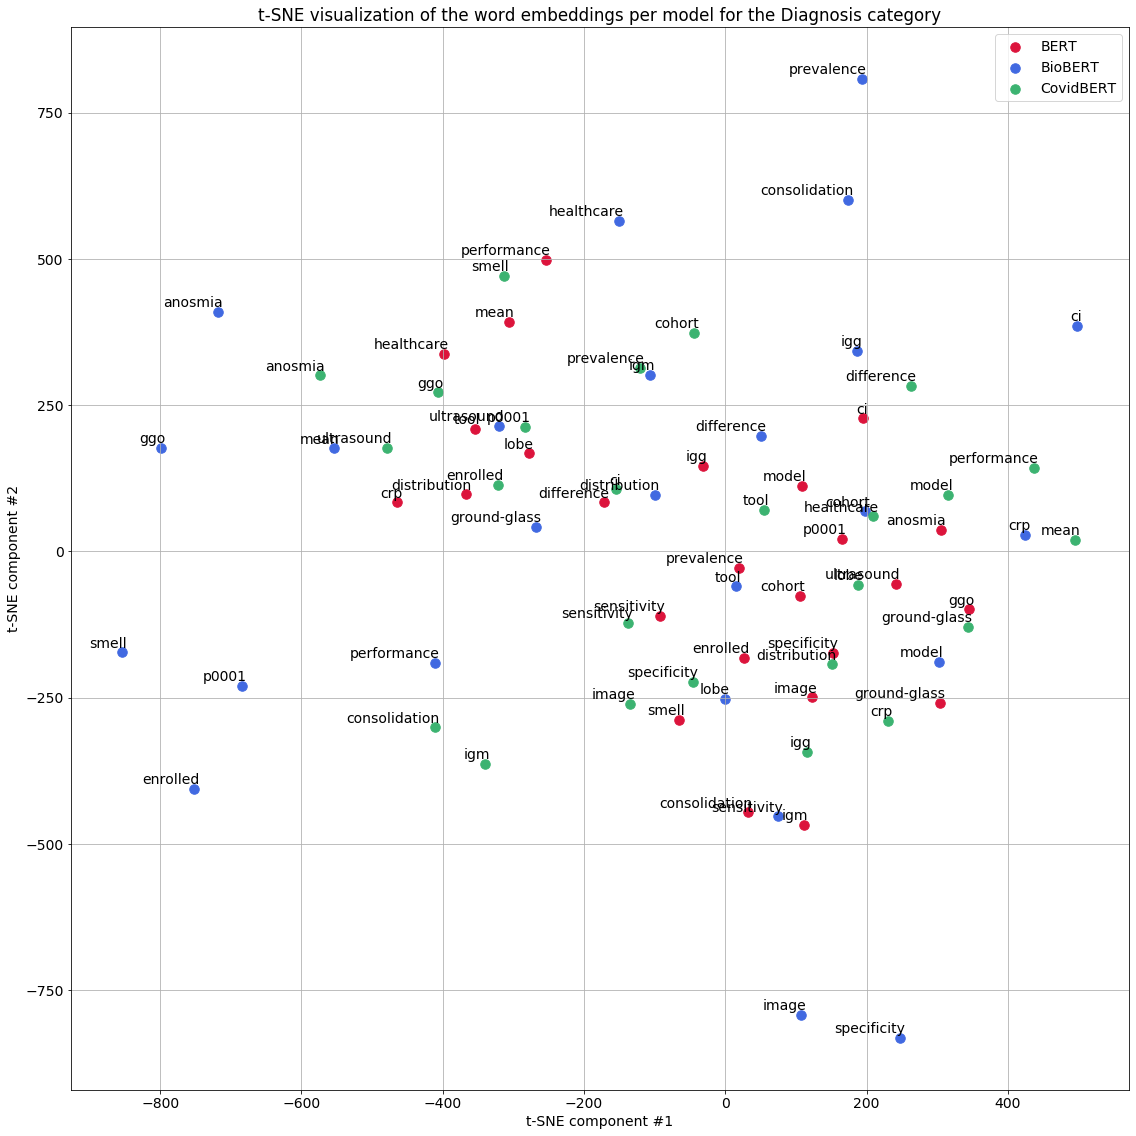

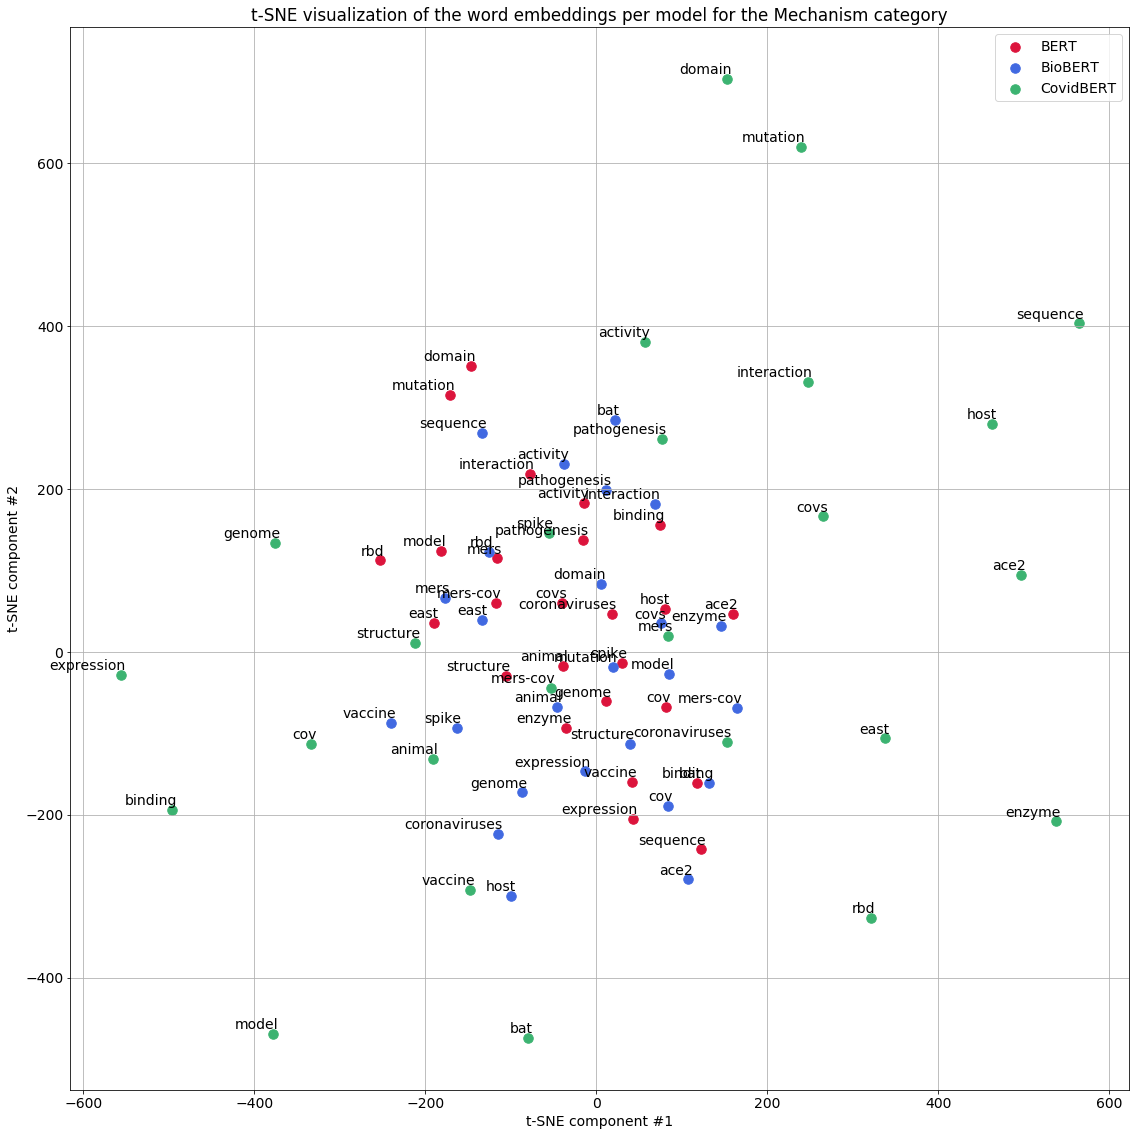

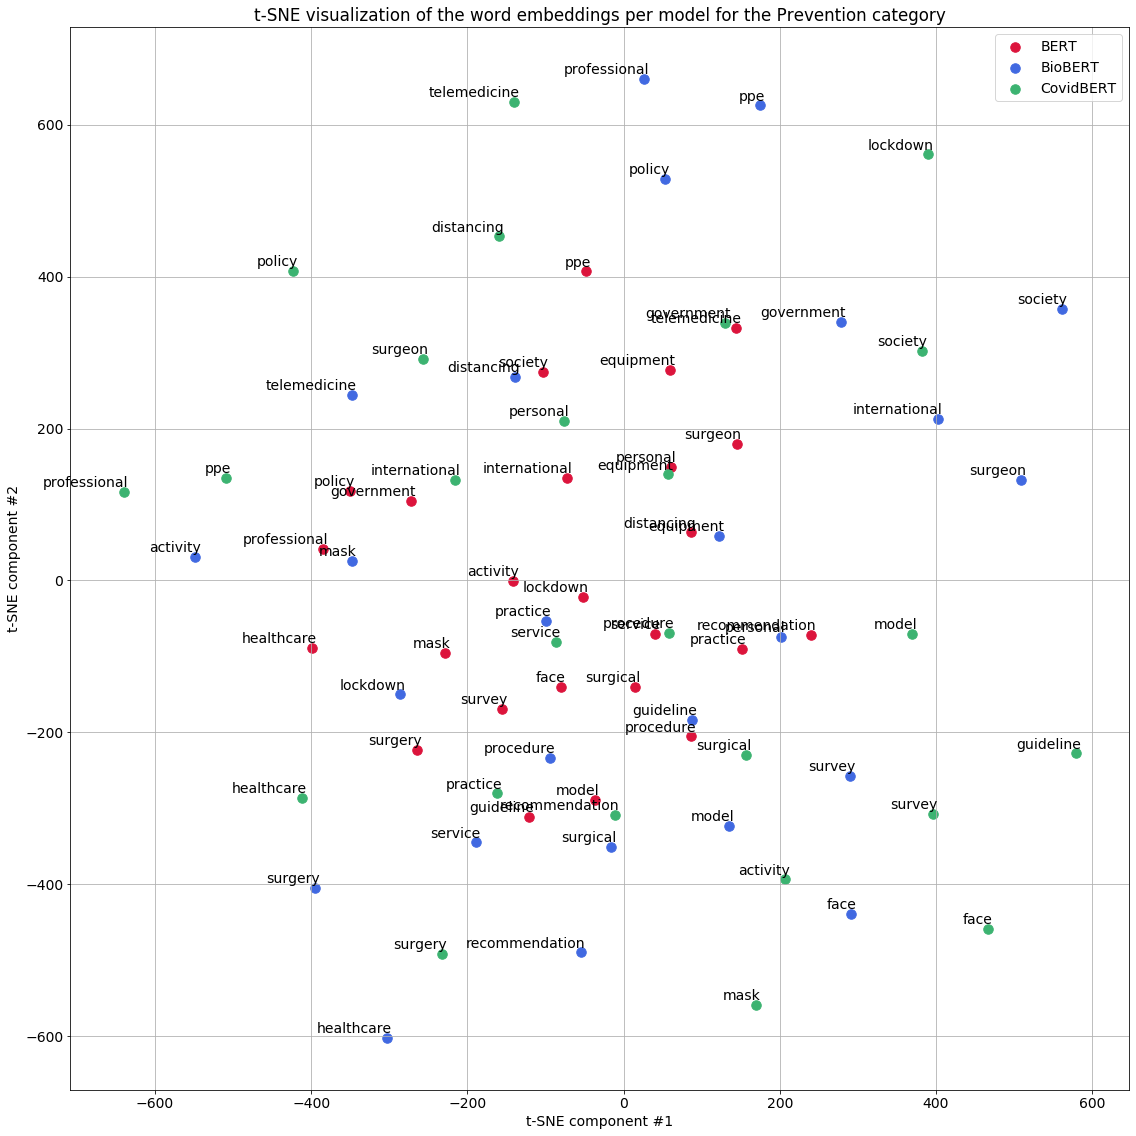

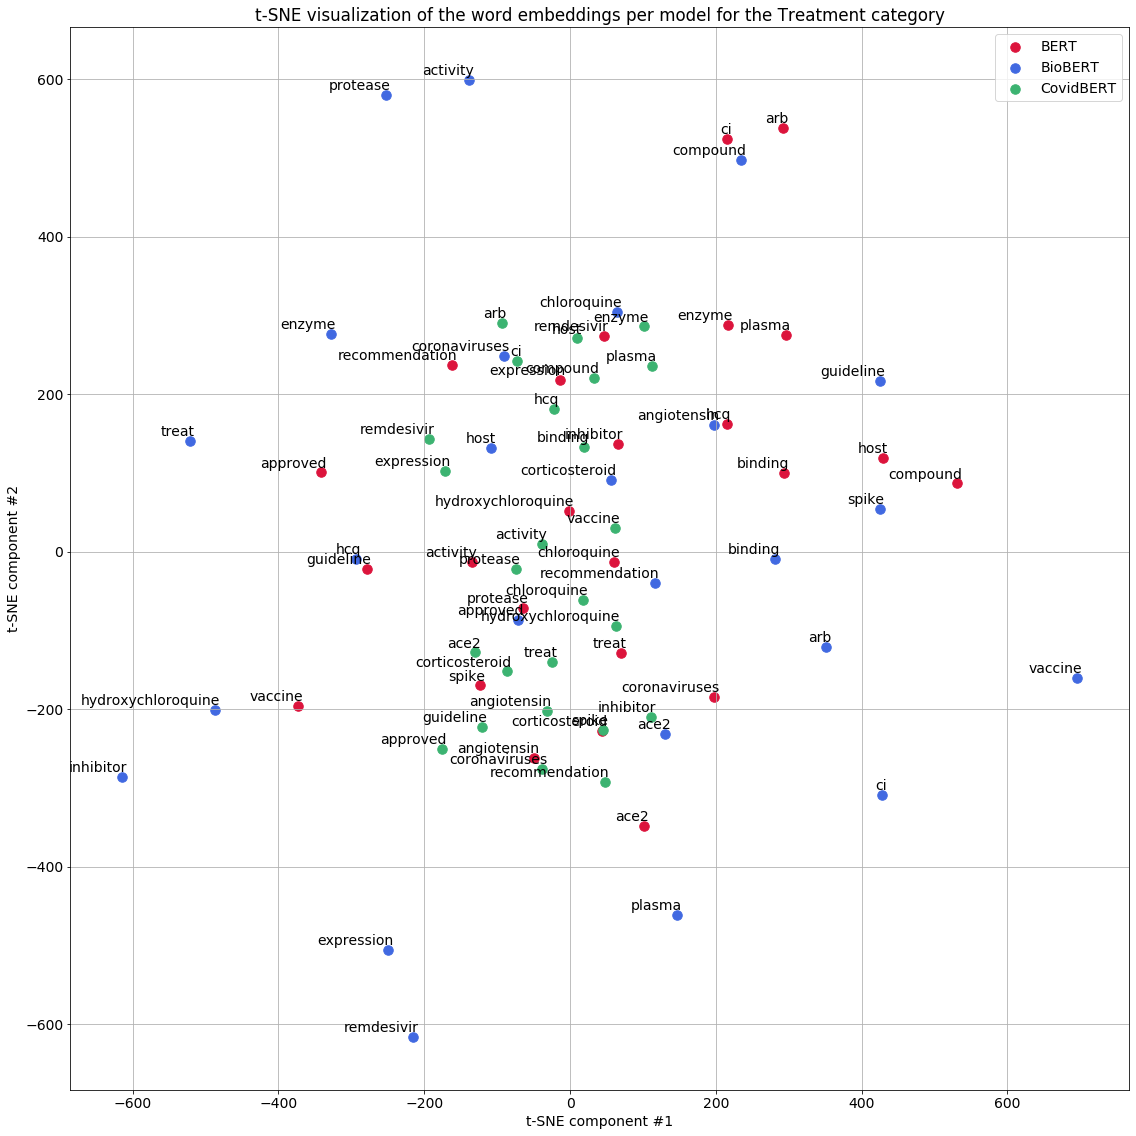

In [82]:
def visualize_per_topic(bert_embeds, biobert_embeds, covidbert_embeds, labels, topic_nr, cat): 
    colors=["crimson", "royalblue", "mediumseagreen"]
    names = ["BERT", "BioBERT", "CovidBERT"]
    
    fig = plt.figure(figsize=(16, 16)) 
    ax1 = fig.add_subplot(111)
    
    plt.rcParams.update({'font.size': 14})
    
    for j, embeds in enumerate([bert_embeds, biobert_embeds, covidbert_embeds]):
        tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1000, random_state=42)
        new_values = tsne_model.fit_transform(embeds[topic_nr])

        x = []
        y = []
        for value in new_values:
            x.append(value[0])
            y.append(value[1])

        ax1.scatter(x,y, color=colors[j], label=names[j], s=90)    
        for i in range(len(x)):
            ax1.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
    
    plt.xlabel("t-SNE component #1")
    plt.ylabel("t-SNE component #2")
    plt.grid()
    
    plt.title("t-SNE visualization of the word embeddings per model for the " + cat + " category")
    plt.legend()
    plt.tight_layout()
    
    plt.savefig("../data/visualization/" + cat + "_tsne_plot.png")
    plt.show()
    
for i in range(len(category_names)):
    visualize_per_topic(bert_embeddings_per_topic, biobert_embeddings_per_topic, 
                        covidbert_embeddings_per_topic, unique_unigrams[i], i, category_names[i])